## Анастасия Куканова, A3200
### Дополнительное задание: алгоритм BFGS

In [1]:
% matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)
import matplotlib.pyplot as plt

from random import random, choice
import math
import numpy as np

#### Исходный код. Заимствования из задания 1

In [2]:
def generate_point(lower, upper):
    return np.array(tuple((l + random() * (u - l)) for l, u in zip(lower, upper)))


def in_range(point, lower, upper):
    return all(tuple(l <= comp <= u for comp, l, u in zip(point, lower, upper)))


def dichotomy(left, right, func, epsilon=0.001):
    step_count = 0
    while right - left >= 2 * epsilon:
        step_count += 1
        mid = (left + right) / 2.0
        delta = random() * (right - left) / 2.0
        new_left = mid - delta
        new_right = mid + delta
        if func(new_left) > func(new_right):
            left = new_left
        else:
            right = new_right
    return (right + left) / 2, step_count


def monte_carlo_hybrid(opt_method, *args, tries=100, **kwargs):
    arg_min, _min = opt_method(*args, **kwargs)
    for _ in range(tries - 1):
        point, value = opt_method(*args, **kwargs)
        if value < _min:
            arg_min, _min = point, value
    return arg_min, _min


#### Исходный код. Алгоритм BFGS

In [3]:
def bfgs(lower, upper, func, grad, epsilon=0.01, save_path=False):
    norm = np.linalg.norm
    max_alpha = norm(upper - lower)
    I = np.identity(len(lower))
    C = I
    current_point = generate_point(lower, upper)
    if save_path:
        path = [current_point]
    while True:
        g = grad(current_point)
        p = np.inner(C, -g)
        p /= norm(p)
        while True:
            alpha, _ = dichotomy(np.array([0]), np.array([max_alpha]), lambda a: func(current_point + a * p),
                                 epsilon=epsilon * 0.01)
            next_point = current_point + alpha * p
            if in_range(next_point, lower, upper) or max_alpha < epsilon * 0.01:
                if save_path:
                    path.append(next_point)
                break
            else:
                max_alpha /= 2.0
        delta_x = next_point - current_point
        if norm(grad(next_point)) < epsilon or norm(delta_x) < epsilon * 0.01:
            if save_path:
                return next_point, func(next_point), path
            else:
                return next_point, func(next_point)
        else:
            delta_g = grad(next_point) - grad(current_point)
            beta = np.inner(delta_g, delta_x)
            C = (I - np.outer(delta_x, delta_g) / beta) * C * (I - np.outer(delta_x, delta_g) / beta) + \
                np.outer(delta_x, delta_x) / beta
            current_point = next_point



#### Исследуемые функции

In [4]:
def rosenbrock(vec):
    result = np.array([sum(map(lambda a: (1.0 - a[0]) ** 2 + 100.0 * (a[1] - a[0] ** 2) ** 2, zip(vec, vec[1:])))])
#     print(result)
    return result


def rosenbrock_grad(vec):
    n = len(vec)
    grad = [-2 * (1 - vec[0]) - 400 * vec[0] * (vec[1] - vec[0] ** 2)]
    for k in range(1, n - 1):
        grad.append(200 * (vec[k] - vec[k - 1] ** 2) - 2 * (1 - vec[k] - 400 * vec[k] * (vec[k + 1] - vec[k] ** 2)))
    grad.append(200 * (vec[n - 1] - vec[n - 2] ** 2))
    return np.array(grad)


def tricky(vec):
    (x, y) = vec
    return np.array([15.0 * math.e**(-(x ** 2 + y ** 2)) * (x ** 2 + y ** 2 - 0.4) + (0.4 ** 6) * (x ** 2 + y ** 2) ** 3])


def tricky_grad(vec):
    (x, y) = vec
    return np.array([
        (2 * x) * (15.0 * math.exp(-(x ** 2 + y ** 2)) * (1.0 - (x ** 2 + y ** 2 - 0.4)) +
                   3 * (0.4 ** 6) * (x ** 2 + y ** 2)**2),
        (2 * y) * (15.0 * math.exp(-(x ** 2 + y ** 2)) * (1.0 - (x ** 2 + y ** 2 - 0.4)) +
                   3 * (0.4 ** 6) * (x ** 2 + y ** 2)**2),
    ])


#### Вспомогательные функции

In [5]:
def stats(results, true_min=0):
    print("Average distance to the minimum: ", end="")
    print(sum([np.linalg.norm(res[0] - true_min) for res in results]) / len(results))


def draw_levels_and_path(lower, upper, func, diapason, paths):
    fig, axs = plt.subplots(1)
    x = np.linspace(lower[0], upper[0], 100)
    y = np.linspace(lower[1], upper[1], 100)
    X, Y = np.meshgrid(x, y)
    levels = np.linspace(*diapason, 100)
    Z = func((X, Y))[0]
    cs = axs.contourf(X, Y, Z, levels=levels, cmap=matplotlib.cm.gist_earth)
    fig.colorbar(cs, ax=axs, format="%.2f")
    for path in paths:
        colors = "bgrcym"
        symbols = "ops*^"
        x_plot = []
        y_plot = []
        for (x, y) in path:
            x_plot.append(x)
            y_plot.append(y)
        plt.plot(x_plot, y_plot, '-'+choice(symbols)+choice(colors))
    plt.grid()
    plt.show()

#### Визуализация экспериментов

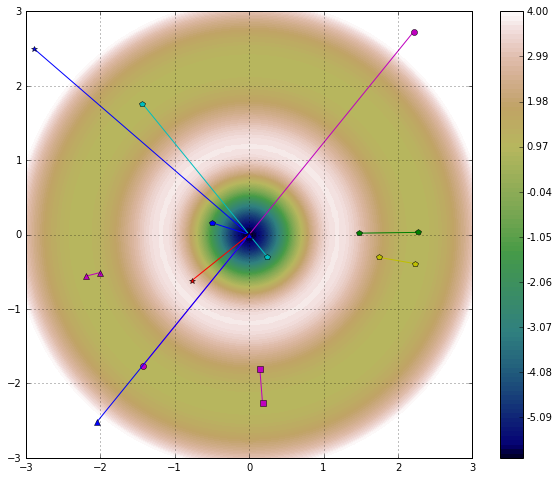

In [6]:
__func__ = tricky
__grad__ = tricky_grad
__lower__ = np.array([-3, -3])
__upper__ = np.array([3, 3])
__diapason__ = [-6, 4]

__paths__ = []
for _ in range(10):
    __arg_min__, __min__, __path__ = bfgs(__lower__, __upper__, __func__, __grad__, save_path=True)
    __paths__.append(__path__)

draw_levels_and_path(__lower__, __upper__, __func__, __diapason__, __paths__)

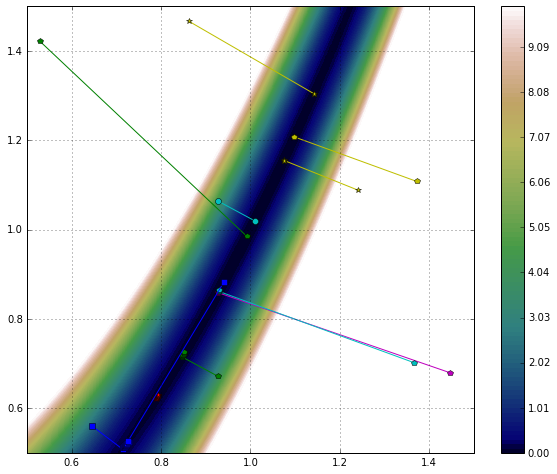

In [10]:
__func__ = rosenbrock
__grad__ = rosenbrock_grad
__lower__ = np.array([0.5, 0.5])
__upper__ = np.array([1.5, 1.5])
__diapason__ = [0, 10]

__paths__ = []
for _ in range(10):
    __arg_min__, __min__, __path__ = bfgs(__lower__, __upper__, __func__, __grad__, save_path=True)
    __paths__.append(__path__)

draw_levels_and_path(__lower__, __upper__, __func__, __diapason__, __paths__)

#### Стохастический гибрид (с методом Монте Карло)

In [16]:
__func__ = tricky
__grad__ = tricky_grad
__lower__ = np.array([-3, -3])
__upper__ = np.array([3, 3])
__true_min__ = np.array([0, 0])


stats([monte_carlo_hybrid(bfgs, __lower__, __upper__, __func__, __grad__, tries=100,
                          epsilon=0.01) for _ in range(10)], __true_min__)

Average distance to the minimum: 8.35764263095e-07


In [14]:
__func__ = rosenbrock
__grad__ = rosenbrock_grad
__lower__ = np.array([0.5, 0.5])
__upper__ = np.array([1.5, 1.5])
__true_min__ = np.array([1, 1])

stats([monte_carlo_hybrid(bfgs, __lower__, __upper__, __func__, __grad__, tries=100,
                          epsilon=0.01) for _ in range(10)], __true_min__)

Average distance to the minimum: 0.00379952636611
